In [11]:
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

import numpy as np
from rdkit.Chem import rdFingerprintGenerator
import deepchem as dc
import random
import optuna

from sklearn.metrics import (
    accuracy_score,
    log_loss,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

from pprint import pprint
import joblib

In [2]:
# Ensure reproducibility with a fixed seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # For deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Set a global seed for reproducibility
SEED = 42
set_seed(SEED)

In [3]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Preprocessing SMILES Data into Graphs

In [4]:
# Featurization using DeepChem's MolGraphConvFeaturizer
from utils.SmilesEnumeration import SmilesEnumerator


def featurize_smiles(smiles):
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    graph_data = featurizer.featurize([smiles])[0]

    # Get DeepChem atom features
    atom_features_deepchem = graph_data.node_features

    return atom_features_deepchem


# Function to generate Morgan Fingerprints (ECFP)
def generate_ecfp(smiles):
    # Morgan fingerprint generator
    mfgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096)

    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return None
    return mfgen.GetFingerprintAsNumPy(molecule)


# Function to convert SMILES to PyTorch Geometric Data object using DeepChem featurizer
def smiles_to_graph_featurizer(smiles):
    # Featurization using DeepChem
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)

    # Featurize the SMILES string using DeepChem
    graph_data = featurizer.featurize([smiles])[0]
    return graph_data.node_features, graph_data.edge_features, graph_data.edge_index


# Function to extract atom features
def atom_features(atom, ecfp):
    # Get the atom index for corresponding ECFP value
    atom_idx = atom.GetIdx()

    return [
        atom.GetAtomicNum(),  # Atomic number
        atom.GetDegree(),  # Number of bonds
        atom.GetTotalNumHs(),  # Total number of hydrogens
        atom.GetFormalCharge(),  # Formal charge of the atom
        atom.GetImplicitValence(),  # Implicit valence
        atom.GetNumRadicalElectrons(),  # Number of radical electrons
        int(atom.GetIsAromatic()),  # Is the atom aromatic?
        atom.GetMass(),  # Atomic mass
        atom.GetHybridization().real,  # Hybridization state (SP, SP2, SP3, etc.)
        ecfp[atom_idx],  # Morgan fingerprint (ECFP) for the atom
    ]


# Function to extract bond features
def bond_features(bond):
    bond_type = bond.GetBondTypeAsDouble()  # Bond type as a float
    is_aromatic = bond.GetIsAromatic()  # Aromatic bond
    is_conjugated = bond.GetIsConjugated()  # Conjugated bond
    is_in_ring = bond.IsInRing()  # Whether the bond is part of a ring
    stereo = bond.GetStereo()  # Bond stereochemistry

    # Convert stereo information to a one-hot encoded format
    stereo_one_hot = [0, 0, 0, 0]  # Stereo options: None, E, Z, Other
    if stereo == Chem.BondStereo.STEREONONE:
        stereo_one_hot[0] = 1
    elif stereo == Chem.BondStereo.STEREOE:
        stereo_one_hot[1] = 1
    elif stereo == Chem.BondStereo.STEREOZ:
        stereo_one_hot[2] = 1
    else:
        stereo_one_hot[3] = 1

    # Combine all features into a single tensor
    return [
        bond_type,
        float(is_aromatic),
        float(is_conjugated),
        float(is_in_ring),
    ] + stereo_one_hot


# Convert SMILES to PyTorch Geometric Data object
def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)

    atom_features_list = []
    edge_index = []
    edge_attr = []

    # DeepChem features
    atom_features_deepchem = featurize_smiles(smiles)

    # Generate Morgan Fingerprint (ECFP)
    ecfp_features = generate_ecfp(smiles)

    # Generate Molecule Graph Convolution features
    mol_graph_node_features, mol_graph_edge_features, mol_graph_edge_index = (
        smiles_to_graph_featurizer(smiles)
    )

    # Nodes (atoms)
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_features(atom, ecfp_features))

    atom_features_list = np.array(atom_features_list)

    # Edges (bonds)
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # Append bidirectional edges for undirected graphs
        edge_index.append([i, j])
        edge_index.append([j, i])

        # Append bond features for both directions
        edge_attr.append(bond_features(bond))
        edge_attr.append(bond_features(bond))

    # Convert atom features to a tensor
    combined_features = np.concatenate(
        (atom_features_list, atom_features_deepchem, mol_graph_node_features), axis=1
    )
    x = torch.tensor(combined_features, dtype=torch.float)

    # Convert edge indices and features to tensors, handle empty edge case
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # combine edge features from ECFP and MolGraphConv
    edge_attr = np.array(edge_attr)
    edge_attr = np.concatenate((edge_attr, mol_graph_edge_features), axis=1)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Label (target)
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


# Function to load data from CSV and apply SMILES augmentation for training
def load_data_from_csv(file_path, augment=False, augment_times=1):
    df = pd.read_csv(file_path)

    if "Train" in file_path:
        print("Filter outliers")
        # calculate the length of the Smiles strings
        df["smiles_len"] = df["Smiles"].apply(lambda x: len(x))
        df = df[df["smiles_len"] <= df["smiles_len"].quantile(0.95)]

    smiles_list = df["Smiles"].values
    labels = df["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0).values

    data_list = []

    # Initialize the SmilesEnumerator for data augmentation
    for smiles, label in zip(smiles_list, labels):
        # For test data, no augmentation, just use canonical SMILES
        graph_data = smiles_to_graph(smiles, label)
        data_list.append(graph_data)

    data_list = []

    # Initialize the SmilesEnumerator for data augmentation
    sme = SmilesEnumerator()
    for smiles, label in zip(smiles_list, labels):
        if augment:
            # Apply SMILES randomization (augmentation) for training data
            for _ in range(augment_times):
                augmented_smiles = sme.randomize_smiles(smiles)
                graph_data = smiles_to_graph(augmented_smiles, label)
                data_list.append(graph_data)
        else:
            # For test data, no augmentation, just use canonical SMILES
            graph_data = smiles_to_graph(smiles, label)
            data_list.append(graph_data)

    return data_list


# Function to load data from parquet and apply SMILES augmentation for training
def load_data_from_parquet(file_path):
    df = pd.read_parquet(file_path)

    smiles_list = df["Smiles"].values
    labels = df["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0).values

    data_list = []

    # Initialize the SmilesEnumerator for data augmentation
    for smiles, label in zip(smiles_list, labels):
        # For test data, no augmentation, just use canonical SMILES
        graph_data = smiles_to_graph(smiles, label)
        data_list.append(graph_data)

    return data_list

In [5]:
# Load training and testing data
training_data = load_data_from_parquet("data/training_class_mixed.parquet")
testing_data = load_data_from_parquet("data/testing_class_mixed.parquet")

In [6]:
# Create data loaders
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=False)

In [7]:
# Training function with AUC and accuracy tracking
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    for data in data_loader:
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
        y_pred.extend(out[:, 1].detach().cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

In [8]:
# Evaluation function with AUC and accuracy tracking
def test(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Move data to GPU
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
            y_pred.extend(out[:, 1].cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

# GCN approach

In [9]:
class GCN(torch.nn.Module):
    def __init__(
        self,
        num_node_features,
        num_classes,
        num_layers=3,
        hidden_dim=64,
        dropout_prob=0.5,
        activation="relu",
    ):
        super(GCN, self).__init__()

        # Store activation function dynamically
        if activation == "relu":
            self.activation = F.relu
        elif activation == "tanh":
            self.activation = F.tanh
        else:
            raise ValueError("Unsupported activation function")

        self.dropout_prob = dropout_prob

        # Dynamically define the GCN layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(num_node_features, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        # Final fully connected layer
        self.fc = torch.nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply GCN layers dynamically
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.activation(x)

        # Global pooling (combine different pooling methods)
        x = torch.cat([global_mean_pool(x, batch), global_add_pool(x, batch)], dim=1)

        # Apply dropout
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        # Final classification layer
        return F.log_softmax(self.fc(x), dim=1)

In [10]:
def objective(trial):
    # Set the seed for reproducibility in this trial
    set_seed(SEED)

    # Suggest hyperparameters
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    dropout_prob = trial.suggest_float("dropout_prob", 0.1, 0.6)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    num_layers = trial.suggest_int("num_layers", 2, 5)  # Suggest number of GCN layers
    activation = trial.suggest_categorical(
        "activation", ["relu", "tanh"]
    )  # Suggest activation function

    # Initialize the model
    model = GCN(
        num_node_features=70,
        num_classes=2,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        dropout_prob=dropout_prob,
        activation=activation,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    best_auc = 0
    early_stop_counter = 0
    patience = 10
    max_epochs = 100
    epoch_count = 0

    # Metrics storage for plotting
    train_acc_history, train_loss_history, train_auc_history = [], [], []
    test_acc_history, test_loss_history, test_auc_history = [], [], []

    for epoch in range(max_epochs):
        epoch_count += 1
        train_loss, train_acc, train_auc = train(
            model, train_loader, optimizer, criterion
        )
        test_loss, test_acc, test_auc = test(model, test_loader, criterion)

        # Store metrics for plotting
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        train_auc_history.append(train_auc)
        test_acc_history.append(test_acc)
        test_loss_history.append(test_loss)
        test_auc_history.append(test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            break

    # Store the number of epochs in the trial's user attributes
    trial.set_user_attr("n_epochs", epoch_count)
    trial.set_user_attr("train_acc_history", train_acc_history)
    trial.set_user_attr("train_loss_history", train_loss_history)
    trial.set_user_attr("train_auc_history", train_auc_history)
    trial.set_user_attr("test_acc_history", test_acc_history)
    trial.set_user_attr("test_loss_history", test_loss_history)
    trial.set_user_attr("test_auc_history", test_auc_history)

    # Return the best AUC score for this trial
    return best_auc

In [11]:
# Run the Optuna study with the fixed seed
study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=50)

[I 2024-11-16 15:33:17,430] A new study created in memory with name: no-name-8bc7c385-2a6f-4acf-bf68-f4fc6146133a
[I 2024-11-16 15:33:25,027] Trial 0 finished with value: 0.733657458563536 and parameters: {'hidden_dim': 116, 'dropout_prob': 0.5753571532049581, 'lr': 0.001570297088405539, 'weight_decay': 0.0002481040974867811, 'num_layers': 2, 'activation': 'relu'}. Best is trial 0 with value: 0.733657458563536.
[I 2024-11-16 15:33:34,188] Trial 1 finished with value: 0.728707182320442 and parameters: {'hidden_dim': 226, 'dropout_prob': 0.40055750587160444, 'lr': 0.001331121608073689, 'weight_decay': 1.2087541473056965e-06, 'num_layers': 5, 'activation': 'relu'}. Best is trial 0 with value: 0.733657458563536.
[I 2024-11-16 15:33:49,133] Trial 2 finished with value: 0.708243093922652 and parameters: {'hidden_dim': 72, 'dropout_prob': 0.19170225492671691, 'lr': 8.17949947521167e-05, 'weight_decay': 0.0001256104370001356, 'num_layers': 3, 'activation': 'tanh'}. Best is trial 0 with value: 

In [12]:
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.7554475138121548
  Params: 
    hidden_dim: 231
    dropout_prob: 0.3543332425071246
    lr: 0.0007656402736244026
    weight_decay: 1.7118701796851756e-05
    num_layers: 4
    activation: relu


In [13]:
from pprint import pprint
pprint(f"Best trial: {study.best_trial.params}")

("Best trial: {'hidden_dim': 231, 'dropout_prob': 0.3543332425071246, 'lr': "
 "0.0007656402736244026, 'weight_decay': 1.7118701796851756e-05, 'num_layers': "
 "4, 'activation': 'relu'}")


In [14]:
n_epochs = trial.user_attrs["n_epochs"]
train_acc_history = trial.user_attrs["train_acc_history"]
train_loss_history = trial.user_attrs["train_loss_history"]
train_auc_history = trial.user_attrs["train_auc_history"]
test_acc_history = trial.user_attrs["test_acc_history"]
test_loss_history = trial.user_attrs["test_loss_history"]
test_auc_history = trial.user_attrs["test_auc_history"]

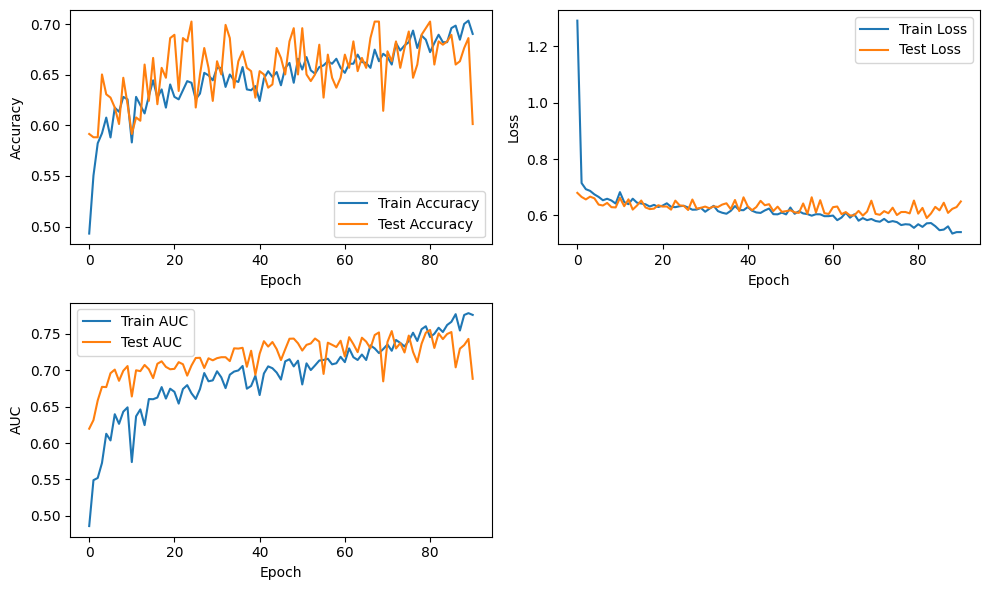

In [15]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# save model
import joblib
joblib.dump(trial, "models/graph_gcn_mixed_filtered_outliers.joblib")

['models/graph_gcn_mixed_filtered_outliers.joblib']

# Rerun best params

In [12]:
# Suggest hyperparameters
trial = joblib.load("models/graph_gcn_mixed_filtered_outliers.joblib")
best_params = trial.params
best_params

{'hidden_dim': 231,
 'dropout_prob': 0.3543332425071246,
 'lr': 0.0007656402736244026,
 'weight_decay': 1.7118701796851756e-05,
 'num_layers': 4,
 'activation': 'relu'}

In [13]:
# Set the seed for reproducibility in this trial
set_seed(SEED)

# Initialize the model
model = GCN(
    num_node_features=70,
    num_classes=2,
    num_layers=best_params["num_layers"],
    hidden_dim=best_params["hidden_dim"],
    dropout_prob=best_params["dropout_prob"],
    activation=best_params["activation"],
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"]
)
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0
early_stop_counter = 0
patience = 10
max_epochs = 100
epoch_count = 0

# Metrics storage for plotting
train_acc_history, train_loss_history, train_auc_history = [], [], []
test_acc_history, test_loss_history, test_auc_history = [], [], []

for epoch in range(max_epochs):
    epoch_count += 1
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion)

    # Store metrics for plotting
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    train_auc_history.append(train_auc)
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    test_auc_history.append(test_auc)

    if test_auc > best_auc:
        best_auc = test_auc
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        break

# Store the number of epochs in the trial's user attributes
print("n_epochs", epoch_count)
print("train_acc_history", train_acc_history)
print("train_loss_history", train_loss_history)
print("train_auc_history", train_auc_history)
print("test_acc_history", test_acc_history)
print("test_loss_history", test_loss_history)
print("test_auc_history", test_auc_history)

n_epochs 60
train_acc_history [0.49303849303849306, 0.5503685503685504, 0.5823095823095823, 0.5921375921375921, 0.6036036036036037, 0.5864045864045864, 0.6093366093366094, 0.6052416052416052, 0.6150696150696151, 0.628992628992629, 0.6076986076986077, 0.6371826371826372, 0.6240786240786241, 0.61998361998362, 0.6248976248976249, 0.6265356265356266, 0.6273546273546273, 0.6420966420966421, 0.6224406224406225, 0.6437346437346437, 0.642915642915643, 0.6437346437346437, 0.6298116298116299, 0.6478296478296478, 0.6461916461916462, 0.6273546273546273, 0.6224406224406225, 0.6478296478296478, 0.638001638001638, 0.6494676494676495, 0.6592956592956593, 0.6486486486486487, 0.6396396396396397, 0.6265356265356266, 0.6404586404586404, 0.6519246519246519, 0.6699426699426699, 0.6502866502866503, 0.647010647010647, 0.6314496314496314, 0.6257166257166257, 0.6560196560196561, 0.6363636363636364, 0.6519246519246519, 0.6396396396396397, 0.6453726453726454, 0.6339066339066339, 0.6511056511056511, 0.643734643734

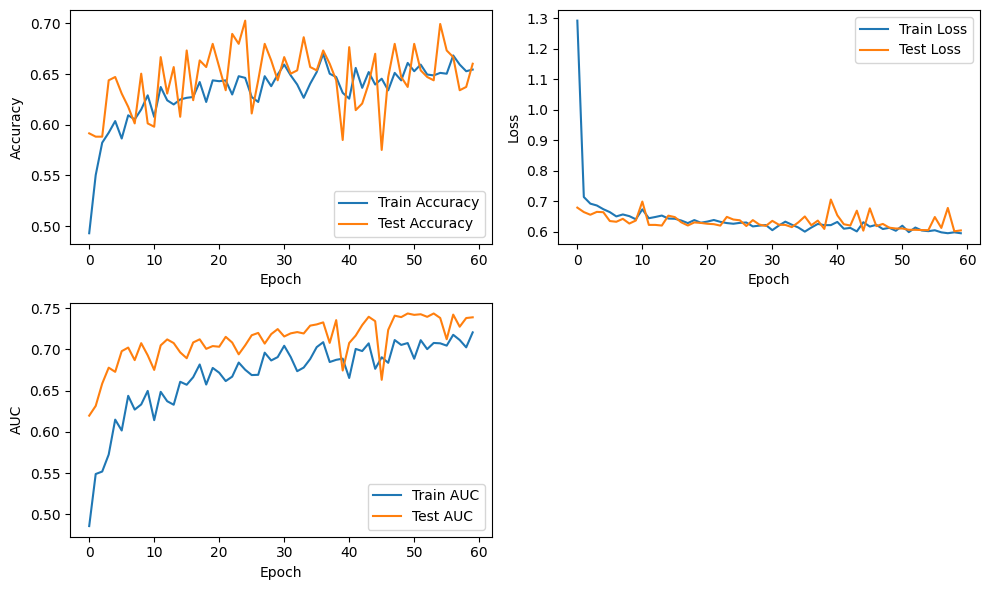

In [14]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# save model
torch.save(model.state_dict(), "models/graph_gcn_mixed_filtered_outliers.pth")

In [16]:
# load model from pth
model = GCN(
    num_node_features=70,
    num_classes=2,
    num_layers=best_params["num_layers"],
    hidden_dim=best_params["hidden_dim"],
    dropout_prob=best_params["dropout_prob"],
    activation=best_params["activation"],
).to(device)

model.load_state_dict(torch.load("models/graph_gcn_mixed_filtered_outliers.pth"))
model.eval()

# make prediction on test set
y_true = []
y_pred_proba = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)  # Move data to GPU
        out = model(data)
        pred = out.argmax(dim=1)
        y_true.extend(data.y.cpu().tolist())  # Move back to CPU for metrics
        y_pred_proba.extend(out[:, 1].cpu().numpy())  # Probability for class 1

auc = roc_auc_score(y_true, y_pred_proba)

# Initialize variables to store the best threshold and performance metrics
best_threshold = 0.5
best_metrics = {
    "accuracy": 0,
    "precision": 0,
    "recall": 0,
    "sensitivity": 0,
    "specificity": 0,
    "f1": 0,
}

# Iterate over possible thresholds
for threshold in np.arange(0.0, 1.0, 0.01):
    # Binarize predictions based on the current threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate precision, recall, accuracy, sensitivity, and specificity
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Same as sensitivity for positive class
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred)

    # Update the best threshold if Youden's J is higher than previous best
    if f1 > best_metrics["f1"]:
        best_threshold = threshold
        best_metrics = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "f1": f1,
        }

# Append results to list
result = {
    "Best Threshold": best_threshold,
    "AUC": auc,
    **best_metrics,
}

pprint(result)

/tmp/ipykernel_82205/1657683086.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/graph_gcn_mixed_filtered_outliers.pth"))
/home/

{'AUC': 0.7389613259668508,
 'Best Threshold': 0.5,
 'accuracy': 0,
 'f1': 0,
 'precision': 0,
 'recall': 0,
 'sensitivity': 0,
 'specificity': 0}


/home/m12gbs1/miniconda3/envs/dili/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/m12gbs1/miniconda3/envs/dili/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/m12gbs1/miniconda3/envs/dili/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/hom